---
# Entropy as an Interpretable Signal in Network Traffic
---

## 1. Motivation

This notebook explores whether **Shannon entropy**, applied to destination port distributions, can act as a *weak but interpretable signal* of anomalous network behaviour.

Rather than attempting to build a detection system, the goal is to construct a **minimal, controlled example** that isolates one idea: how changes in traffic structure affect entropy, and what that response looks like under simple assumptions.

Security-relevant signals are often subtle, mixed, and context-dependent. Before combining signals or applying machine learning, it can be valuable to understand the behaviour of individual measures in isolation. This notebook therefore uses **synthetic traffic** as a deliberately simplified testbed to examine entropy’s characteristics, strengths, and limitations.

---

## 2. Scope and intent

This is an exploratory, analytical exercise rather than a production-ready tool.

The traffic used here is intentionally simplistic and idealised. This allows specific behaviours (such as concentration or dispersion of port usage) to be introduced in a controlled way, making it easier to reason about cause and effect.

The purpose of this notebook is to:
- develop intuition for entropy as a network signal
- observe how it responds to structured changes in traffic
- understand where it may mislead or fail

It is *not* intended to:
- detect real intrusions
- distinguish benign from malicious traffic in isolation
- generalise directly to real enterprise environments

---

## 3. Entropy as a signal

Shannon entropy provides a quantitative measure of **uncertainty or dispersion** in a distribution.

When applied to destination ports:
- low entropy corresponds to traffic concentrated on a small number of ports
- higher entropy corresponds to traffic spread more evenly across many ports


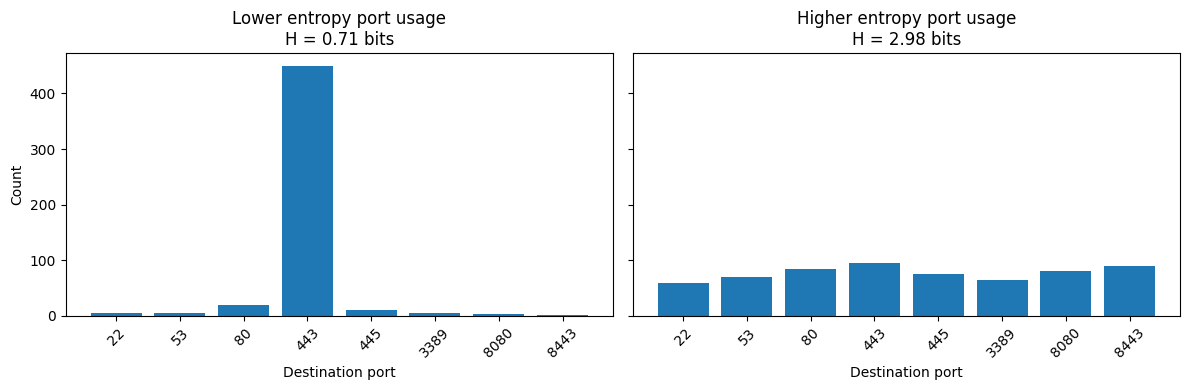

In [2]:
# --- Example plots of low and high entropy distributions in relation to port traffic

import numpy as np
import matplotlib.pyplot as plt

def shannon_entropy(counts: np.ndarray) -> float:
    """Shannon entropy in bits for a discrete distribution given integer counts."""
    counts = np.asarray(counts, dtype=float)
    total = counts.sum()
    if total == 0:
        return 0.0
    p = counts / total
    p = p[p > 0]  # avoid log2(0)
    return float(-(p * np.log2(p)).sum())

# --- "Pretend" port usage (counts) ---
ports = np.array([22, 53, 80, 443, 445, 3389, 8080, 8443])

# Low entropy: most traffic concentrated on a small number of ports
counts_low = np.array([5, 5, 20, 450, 10, 5, 3, 2])

# Higher entropy: traffic more evenly spread across many ports
counts_high = np.array([60, 70, 85, 95, 75, 65, 80, 90])

H_low = shannon_entropy(counts_low)
H_high = shannon_entropy(counts_high)

fig, axes = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

axes[0].bar(ports.astype(str), counts_low)
axes[0].set_title(f"Lower entropy port usage\nH = {H_low:.2f} bits")
axes[0].set_xlabel("Destination port")
axes[0].set_ylabel("Count")

axes[1].bar(ports.astype(str), counts_high)
axes[1].set_title(f"Higher entropy port usage\nH = {H_high:.2f} bits")
axes[1].set_xlabel("Destination port")

for ax in axes:
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()



In a security context, changes in entropy can sometimes coincide with changes in behaviour (for example, scanning activity increasing port diversity). However, entropy itself is **agnostic to intent** and must always be interpreted in context.


---

## 4. Methods

This notebook follows a deliberately simple analytical pipeline designed to isolate the behaviour of a single signal.

1. **Synthetic traffic generation**  
   Network traffic is represented as a sequence of destination ports with associated counts. The distributions are manually constructed to reflect different usage patterns (e.g. concentrated vs dispersed), rather than attempting to simulate full protocol behaviour.


2. **Entropy calculation**  
   Shannon entropy is computed over the destination port distribution. Counts are normalised to probabilities, and zero-probability events are excluded to avoid undefined values.


In [3]:
# --- Definition of entropy calculator: shannon_entropy_from_counts()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

def shannon_entropy_from_counts(counts, base = 2):
    """
    Compute Shannon entropy from a dict / Counter of counts.

    Parameters
    ----------
    counts : dict or collections.Counter
        Keys are outcomes, values are counts.
    base : int or float, optional
        Logarithm base for entropy. base=2 gives bits.

    Returns
    -------
    float
        Shannon entropy.
    """
    total = sum(counts.values())
    if total == 0:
        return 0.0

    probs = np.array(list(counts.values()), dtype=float) / total
    # Filter zero probabilities if they exist; log doesn't like zero
    probs = probs[probs > 0]

    return float(-(probs * np.log(probs) / np.log(base)).sum())



3. **Comparison across scenarios**  
   Entropy values are compared between baseline traffic and modified traffic designed to increase port diversity. This allows the sensitivity of entropy to distributional change to be examined directly.


In [4]:
# --- Definition of port entropy calculator: compute_port_entropy_by_window()
def compute_port_entropy_by_window(df, window_col="time_window", port_col="dest_port"):
    """
    Compute Shannon entropy of destination ports per time window.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns `window_col` and `port_col`.
    window_col : str
        Column representing the time window.
    port_col : str
        Column representing the destination port.

    Returns
    -------
    pd.DataFrame
        DataFrame with columns:
        - time_window
        - entropy_bits
    """
    entropies = []

    for window_value, group in df.groupby(window_col):
        counts = Counter(group[port_col])
        h = shannon_entropy_from_counts(counts, base=2)
        entropies.append({"time_window": window_value, "entropy_bits": h})

    return pd.DataFrame(entropies).sort_values("time_window")



4. **Visualisation**  
   Simple plots are used to show both the underlying port distributions and the resulting entropy values. The emphasis is on interpretability rather than visual sophistication.

All steps are intentionally transparent and minimal. The aim is to understand the behaviour of the signal itself, not to optimise performance or detection accuracy.

---

In [5]:
# --- Definition of shannon_entropy_from_counts()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

# For reproducibility
rng = np.random.default_rng(seed = 42)

def shannon_entropy_from_counts(counts, base = 2):
    """
    Compute Shannon entropy from a dict / Counter of counts.

    Parameters
    ----------
    counts : dict or collections.Counter
        Keys are outcomes, values are counts.
    base : int or float, optional
        Logarithm base for entropy. base=2 gives bits.

    Returns
    -------
    float
        Shannon entropy.
    """
    total = sum(counts.values())
    if total == 0:
        return 0.0

    probs = np.array(list(counts.values()), dtype=float) / total
    # Filter zero probabilities if they exist; log doesn't like zero
    probs = probs[probs > 0]

    return float(-(probs * np.log(probs) / np.log(base)).sum())


In [6]:
# --- Definition of network traffic-producing functions
def generate_baseline_ports(n_flows, rng, common_ports=(80, 443, 22, 53),
                            probs=(0.6, 0.3, 0.05, 0.05)):
    """
    Generate destination ports for baseline traffic.

    Parameters
    ----------
    n_flows : int
        Number of flows to generate.
    rng : np.random.Generator
        Random number generator.
    common_ports : tuple of int
        Ports that represent "normal" services.
    probs : tuple of float
        Probabilities for each common port. Must sum to 1.

    Returns
    -------
    np.ndarray of int
        Array of destination ports.
    """
    return rng.choice(common_ports, size=n_flows, p=probs)


def generate_scan_ports(n_flows, rng, port_min=1, port_max=65535):
    """
    Generate destination ports for a crude scan-like pattern.

    Each flow hits a (roughly) unique port in a wide range once.

    Parameters
    ----------
    n_flows : int
        Number of flows to generate.
    rng : np.random.Generator
        Random number generator.
    port_min, port_max : int
        Inclusive bounds for port numbers.

    Returns
    -------
    np.ndarray of int
        Array of destination ports.
    """
    # Sample without replacement to mimic "one hit per port"
    max_unique = min(n_flows, port_max - port_min + 1)
    ports = rng.choice(
        np.arange(port_min, port_max + 1),
        size=max_unique,
        replace=False
    )
    if max_unique < n_flows:
        # If we need more flows than unique ports, wrap around
        ports = np.resize(ports, n_flows)
    return ports


def generate_synthetic_traffic(
    n_windows=100,
    flows_per_window=200,
    baseline_windows=(1, 60),
    attack_windows=(61, 80),
    post_windows=(81, 100),
    rng=rng
):
    """
    Generate a simple synthetic "NetFlow-like" DataFrame.

    Columns:
    - time_window : int
    - dest_port   : int
    - protocol    : str (optional, here just "TCP" for flavour)
    """
    records = []

    for t in range(1, n_windows + 1):
        if baseline_windows[0] <= t <= baseline_windows[1]:
            # Pure baseline
            dest_ports = generate_baseline_ports(flows_per_window, rng)
        elif attack_windows[0] <= t <= attack_windows[1]:
            # Mixed: half baseline, half scan
            n_half = flows_per_window // 2
            baseline_part = generate_baseline_ports(n_half, rng)
            scan_part = generate_scan_ports(flows_per_window - n_half, rng)
            dest_ports = np.concatenate([baseline_part, scan_part])
        elif post_windows[0] <= t <= post_windows[1]:
            # Back to baseline
            dest_ports = generate_baseline_ports(flows_per_window, rng)
        else:
            # Default to baseline if window not covered
            dest_ports = generate_baseline_ports(flows_per_window, rng)

        for port in dest_ports:
            records.append(
                {
                    "time_window": t,
                    "dest_port": int(port),
                    "protocol": "TCP",  # simple placeholder
                }
            )

    df = pd.DataFrame.from_records(records)
    return df


In [7]:
# --- Generate network traffic flows
flows_df = generate_synthetic_traffic()

In [8]:
# --- Definition of compute_port_entropy_by_window()
def compute_port_entropy_by_window(df, window_col="time_window", port_col="dest_port"):
    """
    Compute Shannon entropy of destination ports per time window.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns `window_col` and `port_col`.
    window_col : str
        Column representing the time window.
    port_col : str
        Column representing the destination port.

    Returns
    -------
    pd.DataFrame
        DataFrame with columns:
        - time_window
        - entropy_bits
    """
    entropies = []

    for window_value, group in df.groupby(window_col):
        counts = Counter(group[port_col])
        h = shannon_entropy_from_counts(counts, base=2)
        entropies.append({"time_window": window_value, "entropy_bits": h})

    return pd.DataFrame(entropies).sort_values("time_window")


## 5. Observations

Under baseline synthetic traffic, entropy remains relatively stable within a narrow range, reflecting consistent port usage patterns.

When traffic is modified to introduce broader port exploration, entropy increases accordingly. This demonstrates that entropy is sensitive to changes in distribution structure, even in this minimal setting.

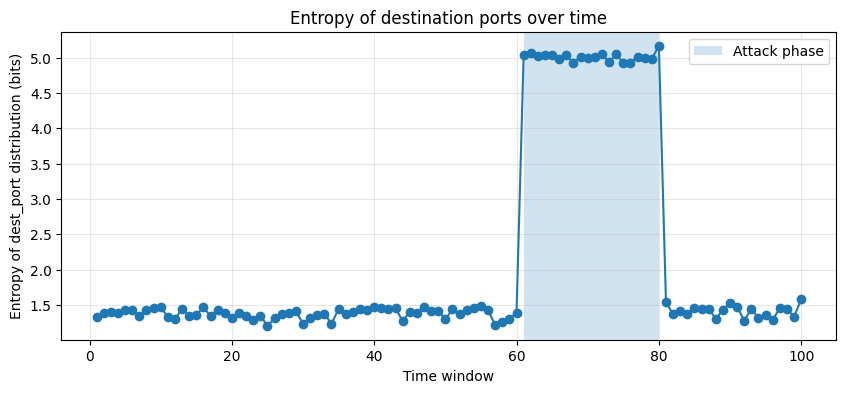

In [9]:
# --- Computing the entropy, plotting the data
entropy_df = compute_port_entropy_by_window(flows_df)

# --- Plot average entropy by sampling window
def plot_entropy_over_time(entropy_df,
                           attack_windows=(61, 80),
                           baseline_windows=(1, 60),
                           post_windows=(81, 100)):
    """
    Plot entropy(time_window) with shaded attack region.
    """
    fig, ax = plt.subplots(figsize=(10, 4))

    ax.plot(
        entropy_df["time_window"],
        entropy_df["entropy_bits"],
        marker="o",
        linestyle="-"
    )

    ax.set_xlabel("Time window")
    ax.set_ylabel("Entropy of dest_port distribution (bits)")
    ax.set_title("Entropy of destination ports over time")

    # Shade attack region
    ax.axvspan(attack_windows[0], attack_windows[1],
               alpha=0.2, label="Attack phase")

    ax.grid(True, alpha=0.3)
    ax.legend(loc="best")

    plt.show()


plot_entropy_over_time(entropy_df)

Importantly, this sensitivity cuts both ways: entropy responds to *any* increase in dispersion, regardless of whether the underlying activity is benign or malicious. This reinforces that entropy is best viewed as a **coarse indicator** rather than a decision rule.

---

## 6. Limitations

Several limitations are explicit and intentional:

- The traffic is synthetic and lacks the diversity, burstiness, and protocol complexity of real networks.
- Legitimate activity (e.g. browsers, updates, CDNs) can produce high entropy without being anomalous.
- Entropy is sensitive to windowing choices and aggregation strategy.
- This signal alone cannot distinguish cause, intent, or risk.

These limitations do not undermine the exercise; rather, they define its boundaries and prevent over-interpretation.

---

## 7. Possible extensions

If extended beyond this minimal example, entropy could be explored as one feature among many, rather than as a standalone indicator. Natural next steps might include:

- applying entropy over sliding time windows
- comparing entropy of ports, IPs, or packet sizes
- testing against benign but high-diversity traffic
- combining entropy with rate-based or temporal features

Such extensions would require real or realistically simulated data and careful validation. They are intentionally out of scope for this notebook.

---
